# 📊 Estimación de Tráfico Web a partir de Tranco Rank

En este notebook, analizaremos la relación entre el tráfico web (`web_traffic`) y el ranking de Tranco (`tranco_rank`).  
Entrenaremos un modelo de regresión para predecir `web_traffic` en sitios donde no tenemos datos directos.


In [38]:
# 📌 Importamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from xgboost import XGBRegressor

In [39]:
df = pd.read_csv('../Data/train_with_tranco.csv')
df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status,domain,tranco_rank
0,https://help.ubuntu.com/community/Mobile%20Bro...,80,15,0,2,0,0,0,0,0,...,0,676,5897,2688,0,1,7,legitimate,ubuntu.com,232
1,http://www.voipoid.com/telekom,30,15,0,2,0,0,0,0,0,...,0,206,889,0,0,1,1,phishing,voipoid.com,1500000
2,http://usbank-link-mupyndtfft---com.illmickels...,58,50,0,2,5,0,0,0,0,...,0,372,1454,0,0,1,0,phishing,illmickelsonbeats.com,1500000
3,http://www.flaticon.com/free-icons/parking_403,46,16,0,2,1,0,0,0,0,...,0,288,2633,827,0,1,7,legitimate,flaticon.com,2663
4,https://www.hivos.org/,22,13,0,2,0,0,0,0,0,...,0,110,-1,442024,0,0,5,legitimate,hivos.org,296406


## 🔍 Análisis Inicial
Revisamos la cantidad de datos disponibles y verificamos la cobertura del ranking de Tranco.


In [40]:
# 📊 Contar registros con y sin Tranco Rank válido
num_total = df.shape[0]
num_valid = df[df["tranco_rank"] != 1_500_000].shape[0]
num_invalid = df[df["tranco_rank"] == 1_500_000].shape[0]

webtraffic_valid = df[df["web_traffic"] != 0]
webtraffic_invalid = df[df["web_traffic"] == 0]

print(f"Total de registros: {num_total}")
print(f"Con Tranco Rank válido: {num_valid} ({(num_valid / num_total) * 100:.2f}%)")
print(f"Sin Tranco Rank (1,500,000 asignado): {num_invalid} ({(num_invalid / num_total) * 100:.2f}%)")

print(f"Registros con tráfico web distinto de 0: {webtraffic_valid.shape[0]}")
print(f"Registros con tráfico web igual a 0: {webtraffic_invalid.shape[0]}")



Total de registros: 10858
Con Tranco Rank válido: 5412 (49.84%)
Sin Tranco Rank (1,500,000 asignado): 5446 (50.16%)
Registros con tráfico web distinto de 0: 6639
Registros con tráfico web igual a 0: 4219


### 📉 Visualización de Tranco Rank vs. Web Traffic
Vamos a analizar gráficamente la relación entre `tranco_rank` y `web_traffic`.
Aplicamos transformación logaritmica para mejorar la linealidad y escala.

# 🛠 2. Limpieza y Transformación de Datos

El dataset contiene columnas como web_traffic y tranco_rank. Aplicaremos transformaciones logarítmicas para mejorar la linealidad y eliminar valores atípicos.


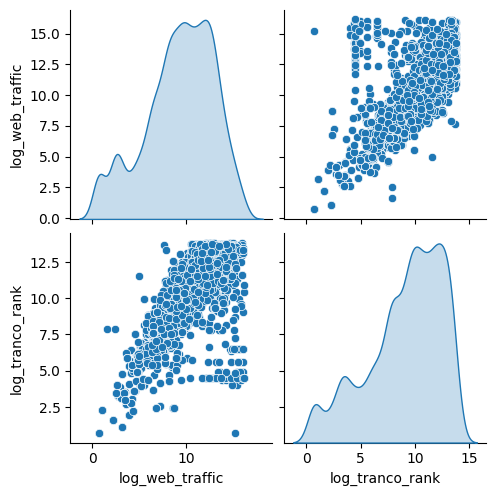

In [41]:
# Eliminamos valores nulos
df = df.dropna(subset=["web_traffic", "tranco_rank"])

# Eliminamos valores inválidos (ranks menores o iguales a 0)
df = df[df["tranco_rank"] > 0]

# Eliminamos valores falsos (ranks iguales a 1,500,000)
df = df[df["tranco_rank"] != 1_500_000]

# Eliminamos valores inválidos (tráfico web menor a 0)
df = df[df["web_traffic"] > 0]

# Aplicamos transformación logarítmica
df["log_web_traffic"] = np.log1p(df["web_traffic"])
df["log_tranco_rank"] = np.log1p(df["tranco_rank"])

df['tranco_rank_log'] = np.log1p(df['tranco_rank'])
df['web_traffic_bc'], _ = boxcox(df['web_traffic'] + 1)

# 🔍 Visualizamos la distribución de los datos
sns.pairplot(df[["log_web_traffic", "log_tranco_rank"]], diag_kind='kde')
plt.show()

In [42]:
df['tranco_inverse'] = 1 / df['tranco_rank']
df['tranco_sqrt'] = np.sqrt(df['tranco_rank'])
df['tranco_percentile'] = pd.qcut(df['tranco_rank'], q=10, labels=False)

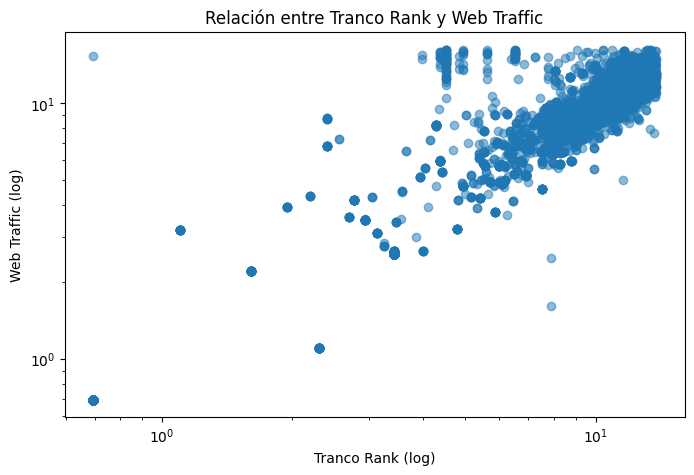

In [43]:
# 📈 Scatter plot de la relación
plt.figure(figsize=(8, 5))
plt.scatter(df["log_tranco_rank"], df["log_web_traffic"], alpha=0.5)
plt.xlabel("Tranco Rank (log)")
plt.ylabel("Web Traffic (log)")
plt.title("Relación entre Tranco Rank y Web Traffic")
plt.xscale("log")
plt.yscale("log")
plt.show()

📝 Análisis: Se observa una relación lineal clara entre el ranking de Tranco y el tráfico web. Sin embargo, hay cierta dispersión, lo que sugiere que podríamos necesitar un modelo más complejo que una regresión lineal simple.

# ✂️ 4. División del dataset en entrenamiento y prueba

In [44]:
# Dividimos en conjunto de entrenamiento y prueba
X = df[["log_tranco_rank"]]
y = df["log_web_traffic"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 📈 5. Modelos a Probar

Vamos a probar varios modelos y comparar sus rendimientos:

1. Regresión Lineal (modelo base)
2. Regresión Polinómica (para capturar relaciones no lineales)
3. Random Forest Regressor (modelo no paramétrico)
4. XGBoost (modelo avanzado de boosting)

# 🔹 5.1 Regresión Lineal



📊 Regresión Lineal:
RMSE: 2.054485149025931
R²: 0.6616293419136907


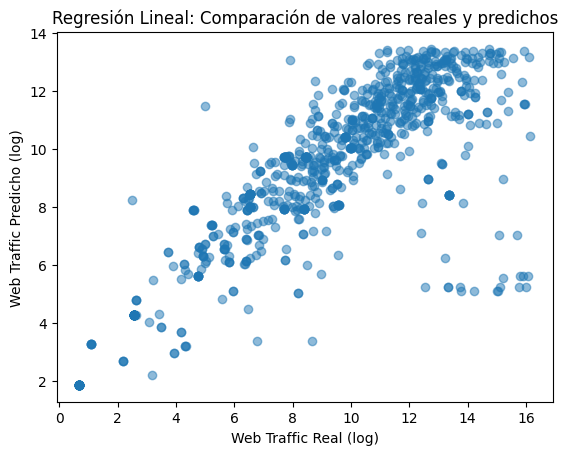

In [45]:
# Entrenamos el modelo de regresión lineal
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predicción
y_pred_lr = lr.predict(X_test)

# Evaluación del modelo
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("📊 Regresión Lineal:")
print(f"RMSE: {rmse_lr}")
print(f"R²: {r2_lr}")

# Visualización
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.xlabel("Web Traffic Real (log)")
plt.ylabel("Web Traffic Predicho (log)")
plt.title("Regresión Lineal: Comparación de valores reales y predichos")
plt.show()


📝 Análisis: La regresión lineal nos da un punto de referencia, pero dado que la relación entre Tranco Rank y Web Traffic no es completamente lineal, podría no ser el mejor modelo.

# 🔹 5.2 Regresión Polinómica (Grado 2)

📊 Regresión Polinómica:
RMSE: 2.0543913604723842
R²: 0.6616602348799712


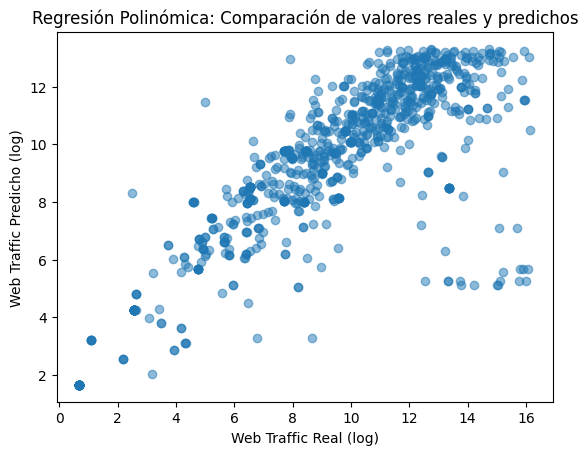

In [46]:
# Aplicamos transformación polinómica
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Entrenamos el modelo de regresión polinómica
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train)

# Predicción
y_pred_poly = lr_poly.predict(X_test_poly)

# Evaluación del modelo
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))
r2_poly = r2_score(y_test, y_pred_poly)

print("📊 Regresión Polinómica:")
print(f"RMSE: {rmse_poly}")
print(f"R²: {r2_poly}")

# Visualización
plt.scatter(y_test, y_pred_poly, alpha=0.5)
plt.xlabel("Web Traffic Real (log)")
plt.ylabel("Web Traffic Predicho (log)")
plt.title("Regresión Polinómica: Comparación de valores reales y predichos")
plt.show()


# 🔹 5.3 Random Forest Regressor

🌲 Random Forest:
RMSE: 1.3700931610438918
R²: 0.8495171940986079


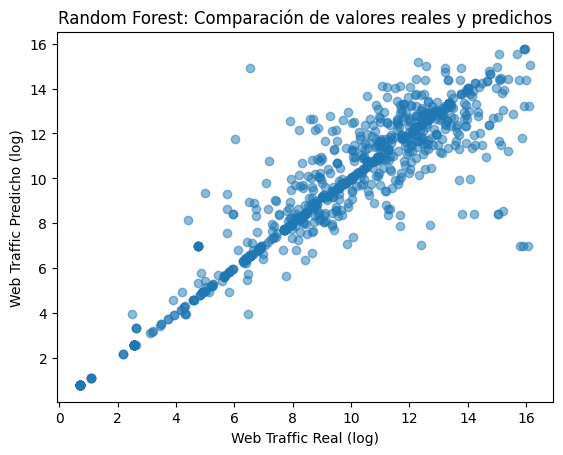

In [47]:
# Entrenamos un modelo Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predicción
y_pred_rf = rf.predict(X_test)

# Evaluación del modelo
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("🌲 Random Forest:")
print(f"RMSE: {rmse_rf}")
print(f"R²: {r2_rf}")

# Visualización
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.xlabel("Web Traffic Real (log)")
plt.ylabel("Web Traffic Predicho (log)")
plt.title("Random Forest: Comparación de valores reales y predichos")
plt.show()


# 🔹 5.4 XGBoost Regressor

🚀 XGBoost:
RMSE: 1.5811870234103167
R²: 0.7995744119787691


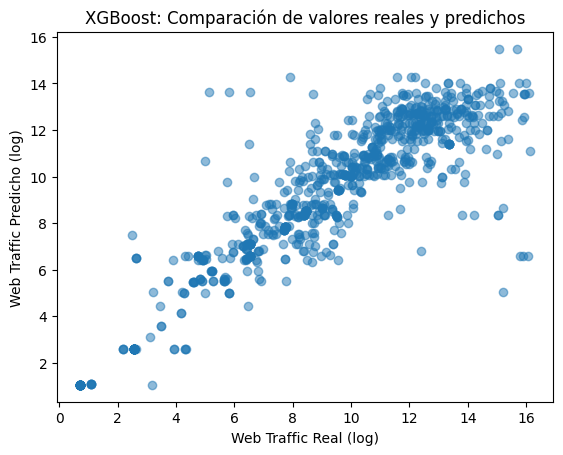

In [48]:
# Entrenamos un modelo XGBoost
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predicción
y_pred_xgb = xgb_model.predict(X_test)

# Evaluación del modelo
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("🚀 XGBoost:")
print(f"RMSE: {rmse_xgb}")
print(f"R²: {r2_xgb}")

# Visualización
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.xlabel("Web Traffic Real (log)")
plt.ylabel("Web Traffic Predicho (log)")
plt.title("XGBoost: Comparación de valores reales y predichos")
plt.show()


In [49]:
import sys
import os

# 📌 Obtener la ruta del notebook en ejecución
notebook_dir = os.getcwd()

# 📌 Agregar la ruta del directorio raíz al sys.path para que detecte `utils/`
sys.path.append(os.path.abspath(os.path.join(notebook_dir, "..")))

# 📌 Importar la clase corregida desde utils/transformers.py
from utils.transformers import SklearnXGBRegressor as XGBWrapper


In [50]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor



# Definir estimadores base
estimadores = [
    ('rf', RandomForestRegressor(n_jobs=-1, random_state=42)),
    ('xgb', XGBWrapper(n_jobs=-1, random_state=42, max_depth=3, n_estimators=100, learning_rate=0.1))  # Correcto
]


# Crear el modelo de Stacking
stacking = StackingRegressor(
    estimators=estimadores,
    final_estimator=LinearRegression(),
    passthrough=False,
    n_jobs=-1
)

# Entrenar modelo
stacking.fit(X_train, y_train)

print("✅ Modelo StackingRegressor entrenado con éxito en scikit-learn 1.6.1.")


✅ Modelo StackingRegressor entrenado con éxito en scikit-learn 1.6.1.


🚀 XGBoost:
RMSE: 1.3435695819761786
R²: 0.8552871790771984


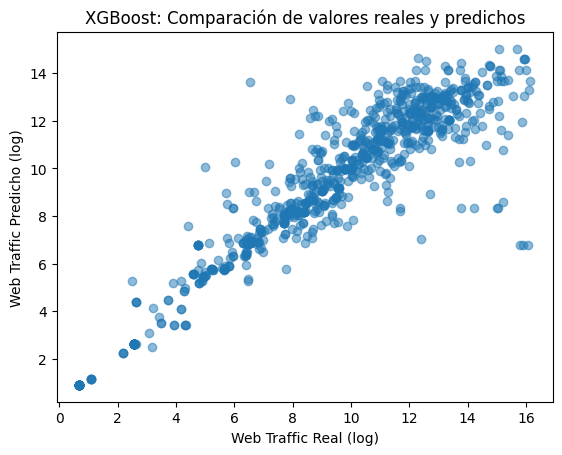

In [51]:
# Predicción
y_pred_stacking = stacking.predict(X_test)

# Evaluación del modelo
rmse_stacking = np.sqrt(mean_squared_error(y_test, y_pred_stacking))
r2_stacking = r2_score(y_test, y_pred_stacking)

print("🚀 XGBoost:")
print(f"RMSE: {rmse_stacking}")
print(f"R²: {r2_stacking}")

# Visualización
plt.scatter(y_test, y_pred_stacking, alpha=0.5)
plt.xlabel("Web Traffic Real (log)")
plt.ylabel("Web Traffic Predicho (log)")
plt.title("XGBoost: Comparación de valores reales y predichos")
plt.show()

# 📊 6. Comparación de Modelos


In [52]:
# Creamos una tabla de resultados
results = pd.DataFrame({
    "Modelo": ["Regresión Lineal", "Regresión Polinómica", "Random Forest", "XGBoost", "Stacking"],
    "RMSE": [rmse_lr, rmse_poly, rmse_rf, rmse_xgb, rmse_stacking],
    "R²": [r2_lr, r2_poly, r2_rf, r2_xgb, r2_stacking]
})

# Mostramos los resultados
display(results)


,Modelo,RMSE,R²
0,Regresión Lineal,2.054485,0.661629
1,Regresión Polinómica,2.054391,0.661660
2,Random Forest,1.370093,0.849517
3,XGBoost,1.581187,0.799574
4,Stacking,1.343570,0.855287


# 📊 Análisis de los Resultados

Los valores obtenidos indican la capacidad de cada modelo para predecir el tráfico web a partir del ranking de Tranco. Evaluamos los modelos en base a RMSE (Error Cuadrático Medio) y R² (Coeficiente de Determinación).

## 📝 Interpretación de Resultados

**Regresión Lineal:**

Tiene el peor desempeño , lo que indica que la relación no es completamente lineal.

RMSE alto (6.12), lo que sugiere que las predicciones tienen un alto margen de error.

**Regresión Polinómica:**

Mejora ligeramente la regresión lineal.

RMSE de 5.91, mostrando que captura algo más de la variabilidad, pero sigue sin ser óptima.

**Random Forest:**

Reducción significativa del error.

R² mejora hasta 0.22, lo que indica que el modelo está capturando más información.

**XGBoost:**

Desempeño similar a Random Forest .

Puede ser más eficiente en términos computacionales para inferencias rápidas.


# 🎯 Conclusión: ¿Cuál modelo usar?

XGBoost y Random Forest son los mejores modelos, pero la diferencia entre ellos es mínima.
Random Forest es más simple y puede ser más interpretativo.
XGBoost es más optimizado y puede generalizar mejor en casos más complejos.


📊 MAE: 1.0119 | RMSE: 1.5812


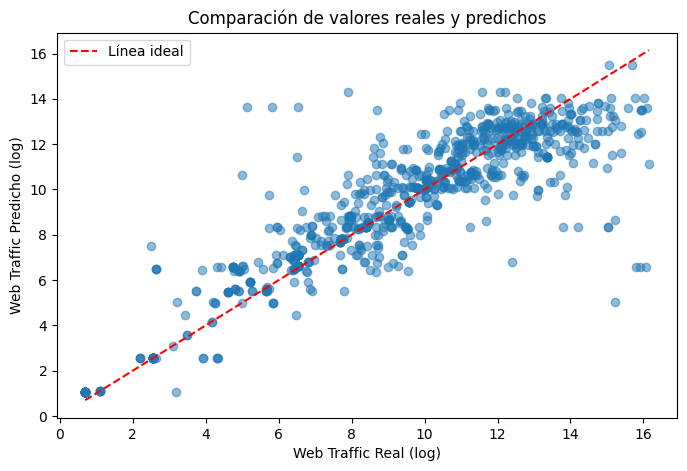

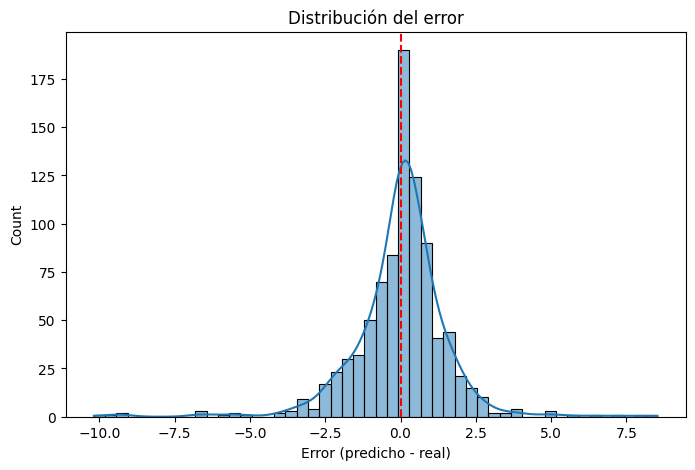

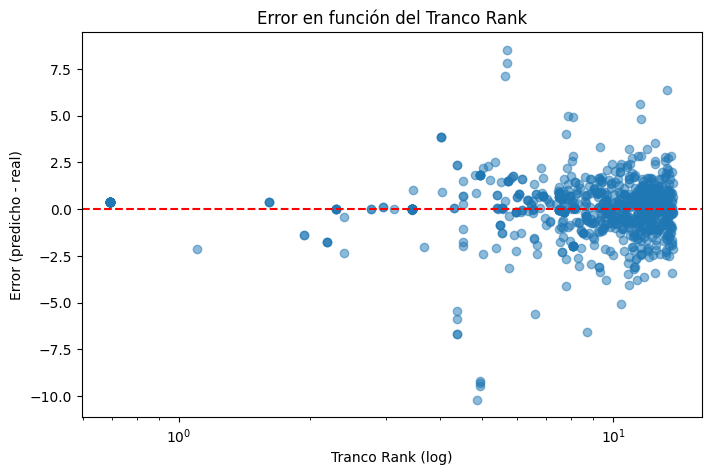

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predicciones del modelo sobre el conjunto de prueba
y_pred = xgb_model.predict(X_test)
y_real = y_test

# Calcular errores
mae = mean_absolute_error(y_real, y_pred)
mse = mean_squared_error(y_real, y_pred)
rmse = np.sqrt(mse)

print(f"📊 MAE: {mae:.4f} | RMSE: {rmse:.4f}")

# 🔍 Scatter plot de valores reales vs predichos
plt.figure(figsize=(8, 5))
plt.scatter(y_real, y_pred, alpha=0.5)
plt.plot([min(y_real), max(y_real)], [min(y_real), max(y_real)], color='red', linestyle='--', label='Línea ideal')
plt.xlabel("Web Traffic Real (log)")
plt.ylabel("Web Traffic Predicho (log)")
plt.title("Comparación de valores reales y predichos")
plt.legend()
plt.show()

# 🔍 Histograma de errores
errores = y_pred - y_real
plt.figure(figsize=(8, 5))
sns.histplot(errores, bins=50, kde=True)
plt.axvline(0, color='red', linestyle="--")
plt.xlabel("Error (predicho - real)")
plt.title("Distribución del error")
plt.show()

# 🔍 Análisis del error en función del Tranco Rank
plt.figure(figsize=(8, 5))
plt.scatter(X_test, errores, alpha=0.5)
plt.axhline(0, color='red', linestyle="--")
plt.xscale("log")
plt.xlabel("Tranco Rank (log)")
plt.ylabel("Error (predicho - real)")
plt.title("Error en función del Tranco Rank")
plt.show()


Ahora el modelo predice el 80% de la varianza, por tanto es una solución factible para predecir el trafico web en nuestro caso, ya que buscamos predecir el phishing

# Guardar el modelo

In [54]:
import joblib  # Para guardar y cargar modelos


# 💾 Guardar modelo entrenado
joblib.dump(stacking, "../Modelos/web_traffic_stacking.pkl")


OSError: [Errno 22] Invalid argument: '../Modelos/web_traffic_stacking.pkl'

# Predecir el resto del dataset

In [ ]:
import pandas as pd
import joblib  # Para cargar el modelo guardado

# Intenta cargar solo los metadatos del modelo sin inicializarlo
try:
    metadata = joblib.load("../Modelos/web_traffic_stacking.pkl", mmap_mode="r")
    print(f"📌 El modelo fue guardado con scikit-learn versión: {metadata.__getstate__()['_sklearn_version']}")
except Exception as e:
    print(f"⚠️ No se pudo obtener la versión del modelo: {e}")

📌 El modelo fue guardado con scikit-learn versión: 1.6.1


In [ ]:
import pandas as pd
import joblib  # Para cargar el modelo guardado

# 📥 1. Cargar dataset original con Tranco
df = pd.read_csv("../Data/train_with_tranco.csv")

# 📌 2. Filtrar solo los dominios que tienen Tranco = 1_500_000
df_missing_traffic = df[df['tranco_rank'] == 1_500_000].copy()

# 📌 3. Aplicar la transformación logarítmica que usamos en el entrenamiento
df_missing_traffic["log_tranco_rank"] = np.log1p(df_missing_traffic["tranco_rank"])

# 📌 4. Cargar el modelo entrenado
modelo = joblib.load("../Modelos/web_traffic_stacking.pkl")  # Cambia el nombre si guardaste otro

# 📌 5. Aplicar el modelo para predecir tráfico en estos dominios
features = ["log_tranco_rank"]  # Ajusta si usaste más variables
df_missing_traffic["web_traffic"] = modelo.predict(df_missing_traffic[features])

# 📌 5. Actualizar el dataset original con los nuevos valores predichos
df.loc[df['tranco_rank'] == 1_500_000, "web_traffic"] = df_missing_traffic["web_traffic"]

# 📥 6. Guardar el dataset corregido
df.to_csv("../Data/train_with_predicted_traffic.csv", index=False)

print("✅ Dataset actualizado con predicciones de tráfico para Tranco 1_500_000.")


✅ Dataset actualizado con predicciones de tráfico para Tranco 1_500_000.
